#Kalman Filters

By Evgenia "Jenny" Nitishinskaya, Dr. Aidan O'Mahony, and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Kalman Filter Beta Estimation Example from [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

##What is a Kalman Filter?

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:
1. Take as input a mathematical model of the system, i.e.
  * the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
  * the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
  * any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
  * covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
2. Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
3. At each timestep:
  * estimate the current state of the system $x_t$ using the transition matrix
  * take as input new measurements $z_t$
  * use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$

[This graphic](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg) illustrates the procedure followed by the algorithm. 

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

In [1]:
%pylab inline
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

Populating the interactive namespace from numpy and matplotlib


# Toy example: falling ball

Imagine we have a falling ball whose motion we are tracking with a camera. The state of the ball consists of its position and velocity. We know that we have the relationship $x_t = x_{t-1} + v_{t-1}\tau - \frac{1}{2} g \tau^2$, where $\tau$ is the time (in seconds) elapsed between $t-1$ and $t$ and $g$ is gravitational acceleration. Meanwhile, our camera can tell us the position of the ball every second, but we know from the manufacturer that the camera accuracy, translated into the position of the ball, implies variance in the position estimate of about 3 meters.

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state. The state of the system is (position, velocity), so it follows the transition matrix
$$ \left( \begin{array}{cc}
1 & \tau \\
0 & 1 \end{array} \right) $$

with offset $(-\tau^2 \cdot g/2, -\tau\cdot g)$. The observation matrix just extracts the position coordinate, (1  0), since we are measuring position. We know that the observation variance is 1, and transition covariance is 0 since we will be simulating the data the same way we specified our model. For the inital state, let's feed our model something bogus like (30, 10) and see how our system evolves.

In [2]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [3]:
# Create a simulation of a ball falling for 40 units of time (each of length tau)
times = np.arange(40)
actual = -4.9*tau**2*times**2

# Simulate the noisy camera data
sim = actual + 3*np.random.randn(40)

# Run filter on camera data
state_means, state_covs = kf.filter(sim)

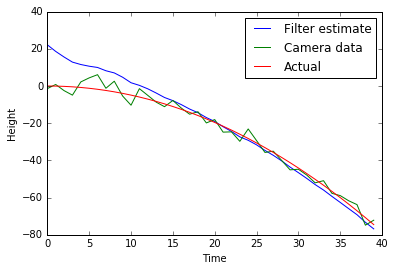

In [4]:
plt.plot(times, state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

In [5]:
print times

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [6]:
print state_means[:,0]

[ 22.14853263  18.59586519  15.58163256  12.84401966  11.5504725
  10.6385403    9.96505999   8.20104296   7.03390728   4.70617119
   1.75612566   0.34190198  -1.51127238  -3.75961345  -6.17721691
  -7.86872811  -9.9920568  -12.38675999 -14.35659047 -16.97121371
 -19.08359635 -21.89597    -24.418308   -27.35554377 -29.19314515
 -31.63487568 -34.62190209 -37.27534368 -40.27340771 -43.5836084
 -46.59233833 -49.69945259 -53.00041872 -55.93902739 -59.33667846
 -62.61252064 -65.92286067 -69.20345799 -73.26635069 -76.82621405]


At each point in time we plot the state estimate <i>after</i> accounting for the most recent measurement, which is why we are not at position 30 at time 0. The filter's attentiveness to the measurements allows it to correct for the initial bogus state we gave it. Then, by weighing its model and knowledge of the physical laws against new measurements, it is able to filter out much of the noise in the camera data. Meanwhile the confidence in the estimate increases with time, as shown by the graph below:

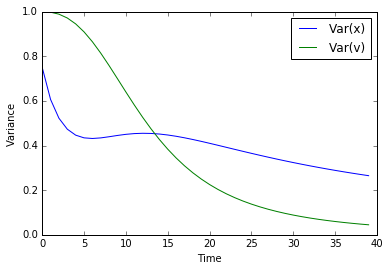

In [7]:
# Plot variances of x and v, extracting the appropriate values from the covariance matrix
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(v)'])
plt.ylabel('Variance')
plt.xlabel('Time');

The Kalman filter can also do <i>smoothing</i>, which takes in all of the input data at once and then constructs its best guess for the state of the system in each period post factum. That is, it does not provide online, running estimates, but instead uses all of the data to estimate the historical state, which is useful if we only want to use the data after we have collected all of it.

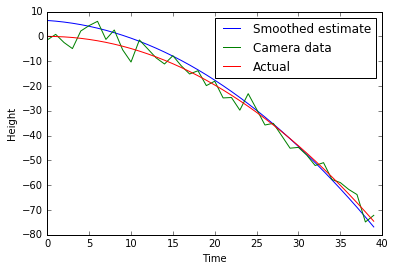

In [8]:
# Use smoothing to estimate what the state of the system has been
smoothed_state_means, _ = kf.smooth(sim)

# Plot results
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

# Example: moving average

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is estimation of rolling parameters of the data. When using a Kalman filter, there's no window length that we need to specify. This is useful for computing the moving average if that's what we are interested in, or for smoothing out estimates of other quantities. For instance, if we have already computed the moving Sharpe ratio, we can smooth it using a Kalman filter.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We hope that the mean describes our observations well, so it shouldn't change too much when we add an observation; therefore, we assume that it evolves as a random walk with a small error term. The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.

In [79]:
df = pd.read_csv("../data/ChungCheonDC/CompositeETCdata.csv")
df_DC = pd.read_csv("../data/ChungCheonDC/CompositeDCdata.csv")
df_DCstd = pd.read_csv("../data/ChungCheonDC/CompositeDCstddata.csv")

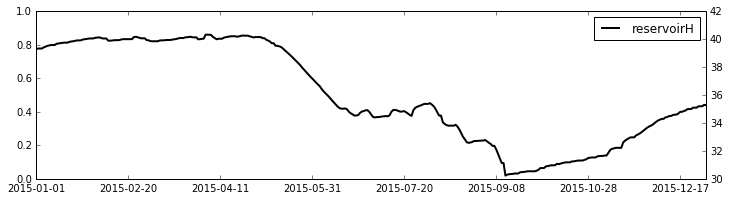

In [80]:
ax1 = plt.subplot(111)
ax1_1 = ax1.twinx()
df.plot(figsize=(12,3), x='date', y='reservoirH', ax=ax1_1, color='k', linestyle='-', lw=2)

In [102]:
print df.reservoirH

0      39.30
1      39.34
2      39.34
3      39.34
4      39.42
5      39.47
6      39.53
7      39.56
8      39.59
9      39.59
10     39.59
11     39.68
12     39.70
13     39.72
14     39.74
15     39.76
16     39.76
17     39.76
18     39.82
19     39.84
20     39.86
21     39.89
22     39.92
23     39.92
24     39.92
25     39.97
26     40.00
27     40.02
28     40.04
29     40.06
       ...  
335    33.88
336    33.99
337    34.09
338    34.18
339    34.24
340    34.29
341    34.30
342    34.40
343    34.43
344    34.50
345    34.50
346    34.57
347    34.60
348    34.60
349    34.68
350    34.80
351    34.80
352    34.86
353    34.90
354    35.00
355    35.00
356    35.00
357    35.10
358    35.10
359    35.10
360    35.20
361    35.20
362    35.20
363    35.30
364    35.28
Name: reservoirH, dtype: float64


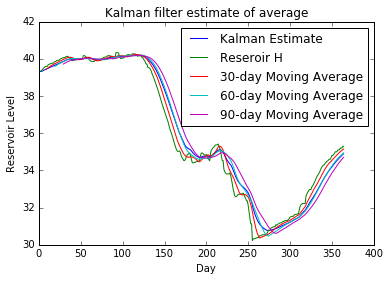

In [82]:
# Load pricing data for a security
# start = '2013-01-01'
# end = '2015-01-01'
#x = get_pricing('reservoirH', fields='price', start_date=start, end_date=end)
x= df.reservoirH
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 39.3,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)

# Compute the rolling mean with various lookback windows
mean10 = pd.rolling_mean(x, 10)
mean20 = pd.rolling_mean(x, 20)
mean30 = pd.rolling_mean(x, 30)

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.plot(mean10)
plt.plot(mean20)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

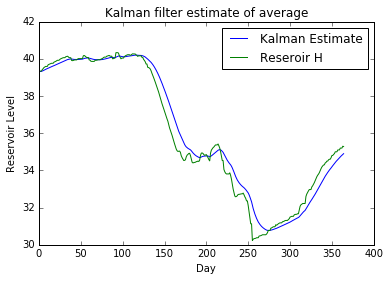

In [83]:
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

This is a little hard to see, so we'll plot a subsection of the graph.

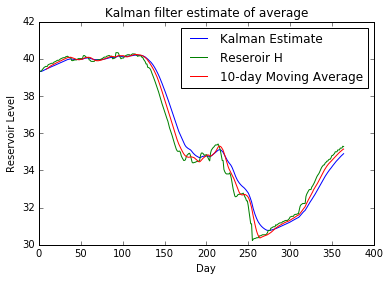

In [84]:
plt.plot(state_means[-400:])
plt.plot(x[-400:])
plt.plot(mean10[-400:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H', '10-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

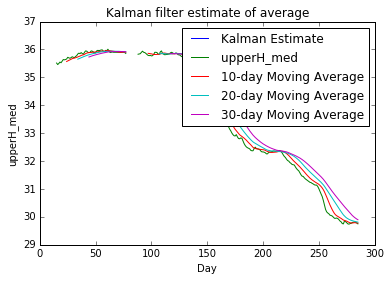

In [105]:
# Load pricing data for a security
# start = '2013-01-01'
# end = '2015-01-01'
#x = get_pricing('reservoirH', fields='price', start_date=start, end_date=end)
xH= df.upperH_med
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 35.5,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(xH.values)

# Compute the rolling mean with various lookback windows
mean10 = pd.rolling_mean(xH, 10)
mean20 = pd.rolling_mean(xH, 20)
mean30 = pd.rolling_mean(xH, 30)

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(xH)
plt.plot(mean10)
plt.plot(mean20)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'upperH_med', '10-day Moving Average', '20-day Moving Average','30-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('upperH_med');

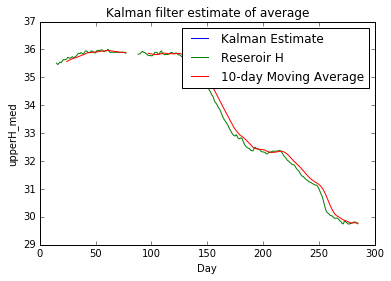

In [106]:
plt.plot(state_means)
plt.plot(xH)
plt.plot(mean10)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H','10-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('upperH_med');

The advantage of the Kalman filter is that we don't need to select a window length, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.

# Generalizations

We can use a Kalman filter to model non-linear transition and observation functions, as well. For this purpose there exist extended and unscented Kalman filters, the latter of which is included in `pykalman`. These can even model situations where noise is not additive (for example, where noise is proportional to the size of the measurement). We can also specify non-Gaussian errors; this is useful in financial data, which tends to have heavy-tailed distributions.

There are also algorithms for inferring some of the input parameters, such as the covariance matrices and initial state, from an initial set of data. This can be done with the `pykalman.em()` method.